In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
# import seaborn as sns

In [30]:
class RidgeRegression:
  def __init__(self):
    self.w = None
  
  def fit(self, X, y, alpha):
    X = np.c_[np.ones(X.shape[0]), X]
    xTranspose = X.T
    A = xTranspose @ X
    I = np.identity(A.shape[0])
    c = xTranspose @ y
    self.w = np.linalg.inv(A + alpha * I) @ c
  
  def predict(self, X):
    X = np.c_[np.ones(X.shape[0]), X]
    return X @ self.w

In [31]:
class LassoRegression:

  def soft_threshold(self, rho, lamda):
    if rho < -lamda:
      return rho + lamda
    elif rho > lamda:
      return rho - lamda
    return 0
  
  def coordinate_descent(self,
                         X,
                         y,
                         lamda = 0.1,
                         n_iterations = 1000,
                         ):
    X = np.array(X)
    X = np.c_[np.ones(X.shape[0]), X]
    y = np.array(y)

    n_features = X.shape[1]
    beta = np.zeros(n_features)
    for _ in range(n_iterations):
      for j in range(n_features):
        X_j = X[:,j]
        r_j = np.dot(X_j, (y - np.dot(X, beta) + beta[j] * X_j))
        penalty = 0 if j == 0 else lamda
        beta[j] = self.soft_threshold(r_j, penalty) / (X_j ** 2).sum()
    return beta

  def predict(self, X, beta):
    X = np.c_[np.ones(X.shape[0]), X]
    return X @ beta 

[My Ridge] Alpha: 0.0001 | Mean Squared Error: 2900.192779070961 | R2 Score: 0.45260292329622887
[My Ridge] Alpha: 0.001 | Mean Squared Error: 2900.185139272314 | R2 Score: 0.4526043652705267
[My Ridge] Alpha: 0.01 | Mean Squared Error: 2900.109234662792 | R2 Score: 0.45261869189103987
[My Ridge] Alpha: 0.1 | Mean Squared Error: 2899.397583807996 | R2 Score: 0.4527530124784023
[My Ridge] Alpha: 1 | Mean Squared Error: 2895.630582222131 | R2 Score: 0.4534640154403162
[My Ridge] Alpha: 10 | Mean Squared Error: 2926.723980555007 | R2 Score: 0.4475952899283333
[My Ridge] Alpha: 100 | Mean Squared Error: 4182.648285813874 | R2 Score: 0.21054577438538835
[Sklearn Ridge] Mean Squared Error: 2899.054555657721
[Sklearn Ridge] R2 Score: 0.45281775734917173


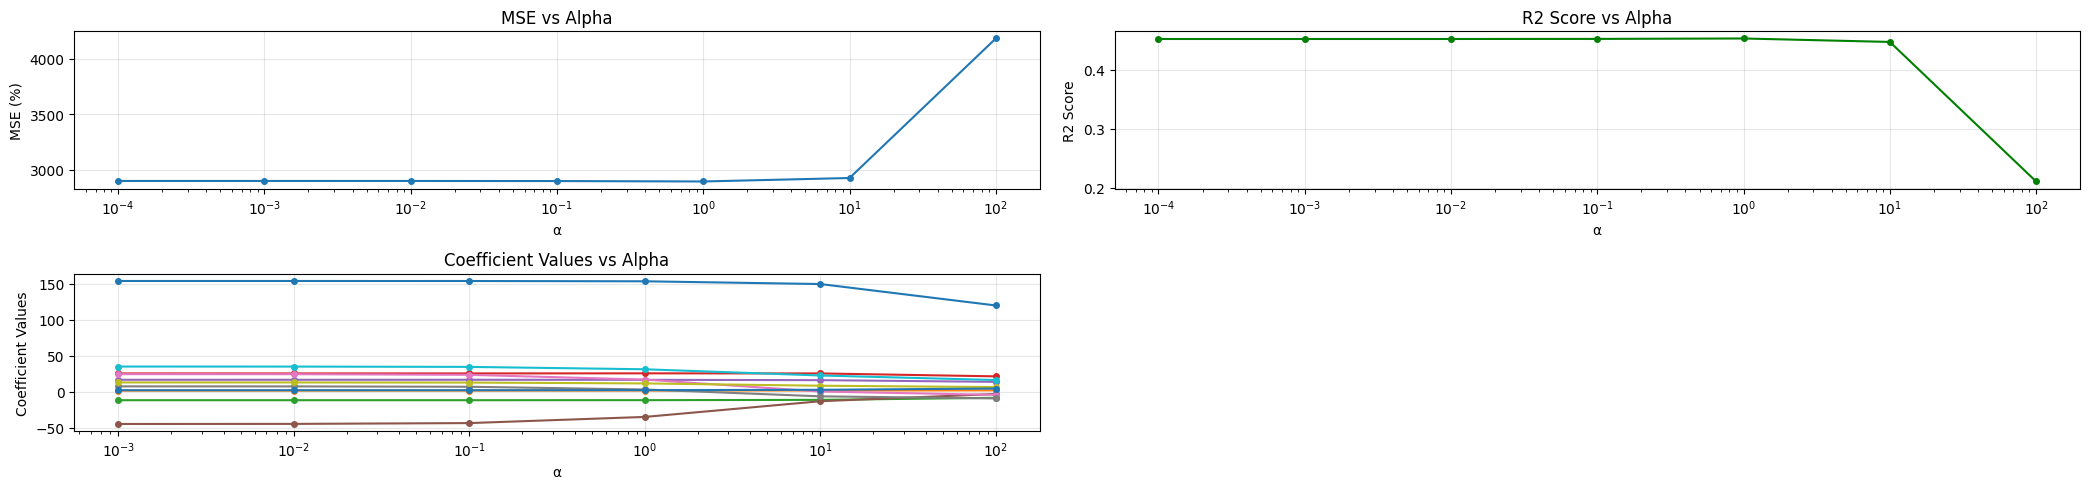

[My Lasso] Mean Squared Error: 2900.1414145569274
[My Lasso] R2 Score: 0.45261261809480613
[Sklearn Lasso] Mean Squared Error: 2884.624288735213
[Sklearn Lasso] R2 Score: 0.455541399027904


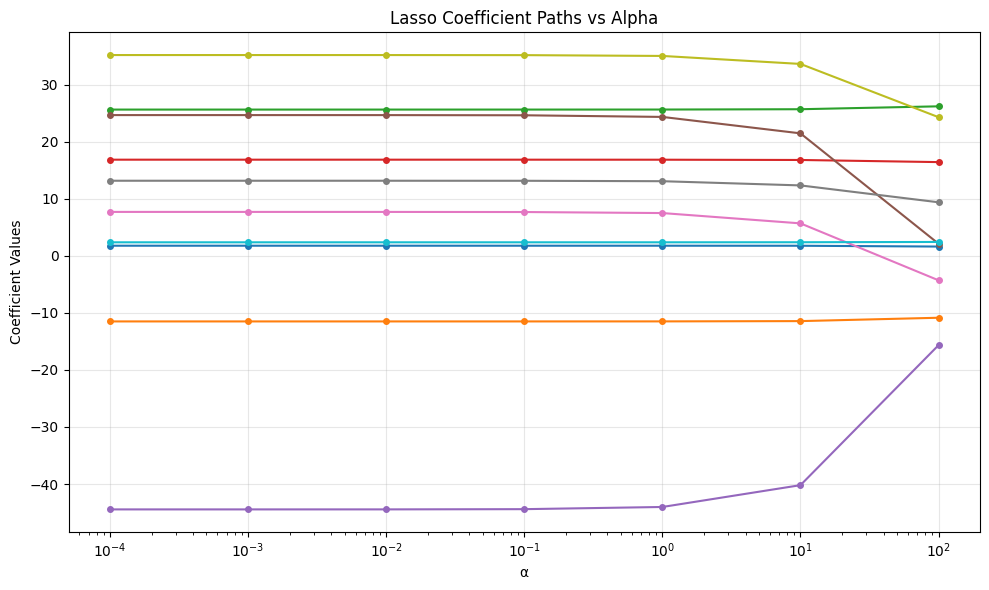

In [32]:
diabetes = load_diabetes()
# sns.heatmap(data.corr(), annot=True)
ridge = RidgeRegression()
lasso = LassoRegression()

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
testMse = []
testR2 = []
coefficients = []

X_train, X_test, y_train, y_test = train_test_split(
  diabetes.data, diabetes.target, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def alphaSweep():
  for a in alphas:
    ridge.fit(X_train, y_train, a)
    y_pred = ridge.predict(X_test)
    testMse.append(mean_squared_error(y_test, y_pred))
    testR2.append(r2_score(y_test, y_pred))
    coefficients.append(ridge.w)
    print(f"[My Ridge] Alpha: {a} | Mean Squared Error: {testMse[-1]} | R2 Score: {testR2[-1]}")

alphaSweep()
ridge_sklearn = Ridge(alpha=0.1)
ridge_sklearn.fit(X_train, y_train)
y_pred_ridge = ridge_sklearn.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("[Sklearn Ridge] Mean Squared Error:", ridge_mse)
print("[Sklearn Ridge] R2 Score:", ridge_r2)

# Plotting Ridge Regression Metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(21, 5))
ax1.plot(alphas, testMse, marker='o', markersize=4)
ax1.set_xscale('log')
ax1.set_xlabel('α')
ax1.set_ylabel('MSE (%)')
ax1.set_title('MSE vs Alpha')
ax1.grid(True, alpha = 0.3)

ax2.plot(alphas, testR2, marker='o', markersize=4, color='green')
ax2.set_xscale('log')
ax2.set_xlabel('α')
ax2.set_ylabel('R2 Score')
ax2.set_title('R2 Score vs Alpha')
ax2.grid(True, alpha = 0.3)

coefficients = np.array(coefficients[1:])
ax3.plot(alphas[1:], np.array(coefficients), marker='o', markersize=4)
ax3.set_xscale('log')
ax3.set_xlabel('α')
ax3.set_ylabel('Coefficient Values')
ax3.set_title('Coefficient Values vs Alpha')
ax3.grid(True, alpha = 0.3)

fig.delaxes(ax4)

plt.tight_layout()
plt.savefig('../images/ridge_metrics.png')
plt.show()

beta_lasso = lasso.coordinate_descent(X_train, y_train, lamda=0.1, n_iterations=1000)
y_pred_lasso = lasso.predict(X_test, beta_lasso)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)
print("[My Lasso] Mean Squared Error:", lasso_mse)
print("[My Lasso] R2 Score:", lasso_r2)


lasso_sklearn = Lasso(alpha=0.1)
lasso_sklearn.fit(X_train, y_train)
y_pred_sklearn = lasso_sklearn.predict(X_test)
sklearn_mse = mean_squared_error(y_test, y_pred_sklearn)
sklearn_r2 = r2_score(y_test, y_pred_sklearn)
print("[Sklearn Lasso] Mean Squared Error:", sklearn_mse)
print("[Sklearn Lasso] R2 Score:", sklearn_r2)

lasso_coefficients = []
for a in alphas:
  beta = lasso.coordinate_descent(X_train, y_train, lamda=a, n_iterations=1000)
  lasso_coefficients.append(beta[1:])  # Exclude intercept

lasso_coefficients = np.array(lasso_coefficients)

plt.figure(figsize=(10, 6))
plt.plot(alphas, lasso_coefficients, marker='o', markersize=4)
plt.xscale('log')
plt.xlabel('α')
plt.ylabel('Coefficient Values')
plt.title('Lasso Coefficient Paths vs Alpha')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/lasso_coefficient_paths.png')
plt.show()
